## A Pluto.jl notebook ###
v0.19.20

In [1]:
using Markdown
using InteractiveUtils

In [2]:
# ╔═╡ f3409cd7-185b-4a35-925e-0d38ea1de729
# Import packages
begin
	# Basics:
	using Distributions
	using Statistics
	#using Mathematics
	# For kth-nearest-neighbour:
	# using Distances
	# For setting a random seed:
	using Random
	# For plotting:
	# using PlotlyBase
	# using PlotlyJS
	# using PyPlot
	using Plots
	# Backend for the Plots package:
	gr()
	# For randomly sampling from an array:
	using StatsBase
	# For nearest-neighbour searches:
	using NearestNeighbors
end

In [3]:
# ╔═╡ 78249b6e-9d72-11ed-2c77-a51efb914f64
md"""
# Variation on SMOTE
"""

# Variation on SMOTE


In [4]:
# ╔═╡ a35d9b03-162f-4367-9360-f751e7a42963
md"""## Setup:"""

## Setup:


In [5]:
# ╔═╡ d15f0f81-ab21-4ad8-95ea-393ca4ba46c9
md"""
### Distances from real points

Select an option for determining the distances of the synthetic points from the real data.

For all options, all synthetic points are at the nearest-neighbour distance of their real counterparts scaled by a factor $\gamma$. The options change the value of $\gamma$:

1. $\gamma=1$
2. $\gamma=\left(\frac{N-1}{M}\right)^\frac{1}{d}$
3. Sample $\gamma$ from the normal distribution $\log\left(\gamma_i\right) \sim \mathcal{N}\left(\frac{1}{d} \log{\frac{N-1}{M}}, \sigma^{2}  \right)$.
"""

### Distances from real points

Select an option for determining the distances of the synthetic points from the real data.

For all options, all synthetic points are at the nearest-neighbour distance of their real counterparts scaled by a factor $\gamma$. The options change the value of $\gamma$:

1. $$
    \gamma=1
    $$
2. $$
    \gamma=\left(\frac{N-1}{M}\right)^\frac{1}{d}
    $$
3. Sample $\gamma$ from the normal distribution $\log\left(\gamma_i\right) \sim \mathcal{N}\left(\frac{1}{d} \log{\frac{N-1}{M}}, \sigma^{2}  \right)$.


In [6]:
# ╔═╡ 40f0420c-6998-4264-8cf9-16291ea03e52
option_distance = 3

3

In [7]:
# ╔═╡ 5269cdf0-2a11-4d1b-803a-78a2c7231d35
md"""### Number of points"""

### Number of points


In [8]:
# ╔═╡ d860a3e7-958f-4919-9db5-658b58ed6b20
begin
	# Number of real samples:
	N = 100
	# Number of synthetic points:
	M = 100
end

100

In [9]:
# ╔═╡ 6e1d209c-8080-4450-95a1-779ba5958c5e
md"""
## Make the real data points

First create the distribution that the points will be sampled from:
"""

## Make the real data points

First create the distribution that the points will be sampled from:


In [10]:
# ╔═╡ 199a9109-2919-47e4-8b20-f1a1eb311177
# Set up a 2D Gaussian distribution.
begin
	# Mean in x, mean in y
	prob_density_mean = [50, 2]
	# Spread in x, covariance with y(?);
	# spread in y, covariance with x(?)
	prob_density_c = [1 0.8; 0.8 1] #[10 0.8; 0.8 1]
	# Create this MultiVariate Normal dist:
	prob_density_function = MvNormal(prob_density_mean, prob_density_c)
end

FullNormal(
dim: 2
μ: [50.0, 2.0]
Σ: [1.0 0.8; 0.8 1.0]
)


In [11]:
# ╔═╡ 3623d487-93ae-4a23-a316-9490889173d8
md"""Then sample a set of `N` real coordinates."""

Then sample a set of `N` real coordinates.


In [12]:
# ╔═╡ 1061dd5b-9a6a-4319-90d8-3c9c59ab92f6
begin
	Random.seed!(42)
	# Sample N sets of coordinates from the 2D Gaussian:
	coords_real = rand(prob_density_function, N)
	# Number of dimensions:
	d = size(coords_real)[1]
end

2

In [13]:
# ╔═╡ 012824a4-deac-4f3a-95b8-cd349077c6e6
md"""
Julia notes:

+ To extract coordinates for one data point, use `real_coords[:, 1]`. 

+ The x-coordinates of all points are `real_coords[1, :]`. 

+ The y-coordinates of all points are `real_coords[2, :]`.
"""

Julia notes:

  * To extract coordinates for one data point, use `real_coords[:, 1]`.
  * The x-coordinates of all points are `real_coords[1, :]`.
  * The y-coordinates of all points are `real_coords[2, :]`.


In [14]:
# ╔═╡ 98d1178d-2936-4fd6-82d9-ac5fa5b4f637
md"""
## Make the synthetic data

We'll define functions for various steps towards making the synthetic data, and later bring them all together in a wrapper function.

| Step | Function | Description |
| --- | --- | --- |
| 1 | `standardise_base` | Standardise the base data |
| 2 | `find_sorted_neighbour_distances` | Find the distances from all base coordinates to all other base coordinates. For N coords, gives an NxN array. The resulting array is sorted so the first row contains the distances to the each point's nearest neighbour (itself). |
| 3 | `get_indices_of_base_points` | Allocate synthetic points to real points |
| 4 | `get_indices_of_neighbours` | Select which of the five nearest neighbours to use. Different choice for each synthetic point. |
| 5 | `get_distances_to_nth_neighbours` | Find the distances to the nth nearest neighbours from Step 2. |
| 6 | `make_distances_from_base_points` | Define new distances from the base points to the new point using the $\gamma$ scale factor. |
| 7 | `get_random_angles` | Define random angles between each synthetic point and its base point. |
| 8 | `make_synth_coords` | Create the synthetic points by combining the angles and distances above with the base data.  |
| 9 | `unstandardise_synth` | Remove standardisation from synth data. |
"""

## Make the synthetic data

We'll define functions for various steps towards making the synthetic data, and later bring them all together in a wrapper function.

| Step |                          Function |                                                                                                                                                                                                                         Description |
| ----:| ---------------------------------:| -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|    1 |                `standardise_base` |                                                                                                                                                                                                           Standardise the base data |
|    2 | `find_sorted_neighbour_distances` | Find the distances from all base coordinates to all other base coordinates. For N coords, gives an NxN array. The resulting array is sorted so the first row contains the distances to the each point's nearest neighbour (itself). |
|    3 |      `get_indices_of_base_points` |                                                                                                                                                                                            Allocate synthetic points to real points |
|    4 |       `get_indices_of_neighbours` |                                                                                                                                      Select which of the five nearest neighbours to use. Different choice for each synthetic point. |
|    5 | `get_distances_to_nth_neighbours` |                                                                                                                                                                       Find the distances to the nth nearest neighbours from Step 2. |
|    6 | `make_distances_from_base_points` |                                                                                                                                         Define new distances from the base points to the new point using the $\gamma$ scale factor. |
|    7 |               `get_random_angles` |                                                                                                                                                               Define random angles between each synthetic point and its base point. |
|    8 |               `make_synth_coords` |                                                                                                                                         Create the synthetic points by combining the angles and distances above with the base data. |
|    9 |             `unstandardise_synth` |                                                                                                                                                                                             Remove standardisation from synth data. |


In [15]:
# ╔═╡ 27d9108f-6ec8-4b0f-8ec3-1a05e4a11064
md"""
### 1. Standardise the base data

Standardise by subtracting the mean and dividing by the standard deviation.
"""

### 1. Standardise the base data

Standardise by subtracting the mean and dividing by the standard deviation.


In [16]:
# ╔═╡ 96747592-972b-431e-891f-879a3695ad6a
function standardise_base(coords_base, d)
	mean_base = mean(coords_base, dims=d)
	std_base = std(coords_base, dims=d)
	# Keep the . in front of the operators for element-wise operation.
	coords_base_standardised = (coords_base .- mean_base) ./ std_base

	# Sanity check
	for (i, axis) in enumerate(["x", "y"])
		if round(std(coords_base_standardised[i, :]), digits=7) != 1
			print("Error in std in ", axis, "\n")
		end
		if round(mean(coords_base_standardised[i, :]), digits=7) != 0
			print("Error in mean in ", axis, "\n")
		end
	end

	return coords_base_standardised, mean_base, std_base
end

standardise_base (generic function with 1 method)

In [17]:
# ╔═╡ 6b279292-6195-4a86-8185-18833c032c7d
md"""
### 2: Calculate average nearest-neighbour distance
"""

### 2: Calculate average nearest-neighbour distance


In [18]:
# ╔═╡ 836e7b57-cfcd-45ca-8eb4-534aca5c563a
function find_sorted_neighbour_distances(coords_base; d=2)
	"""
	Input coords should be standardised.
	
	The average nth nearest-neighbour distance is the mean of the values in row n.
	"""
	# Get distance from each point to every other point.
	# The result is an NxN array if coords_base has N coords in it:
	all_distances = pairwise(Euclidean(), coords_base, dims=d)
	# Sort the full array so that the first row contains 
	# the distance from each point to itself (=zero), 
	# the second row contains the distance from each point 
	# to its nearest neighbour, the third row the distance to the 
	# second-nearest neighbour and so on.
	sorted_distances = sort(all_distances, dims=1)
	# The list of nearest-neighbour distances (where each real data point gets a different distance) is:
	# distances_1st_nearest_real = sorted_distances[2, :]
	return sorted_distances
end

find_sorted_neighbour_distances (generic function with 1 method)

In [19]:
# ╔═╡ f9ebe451-2eeb-4675-918d-7cbf23fa616d
md"""
### 3. Allocate synthetic points to real points

Decide which real data point will be used to generate each synthetic point. Currently these indices are selected at random. 

Julia notes:

+ `rand(1:N, M)` generates `M` values. Each value is in the range `1:N`.
+ The `return` statement is optional in this case. Default behaviour without a `return` line is to return the last thing defined in the function.
"""

### 3. Allocate synthetic points to real points

Decide which real data point will be used to generate each synthetic point. Currently these indices are selected at random. 

Julia notes:

  * `rand(1:N, M)` generates `M` values. Each value is in the range `1:N`.
  * The `return` statement is optional in this case. Default behaviour without a `return` line is to return the last thing defined in the function.


In [20]:
# ╔═╡ 4c90f881-c058-4bb4-ba77-62f74f996478
function get_indices_of_base_points(N, M; random_seed=42)
	# Set the random seed:
	Random.seed!(random_seed)
	# Define indices:
	indices_random = rand(1:N, M)
	return indices_random
end

get_indices_of_base_points (generic function with 1 method)

In [21]:
# ╔═╡ 148c7d7c-00ab-44c6-8271-867090f6bdb3
md"""
### 4. Select which of the n$^{\mathrm{th}}$ nearest neighbours to use
"""

### 4. Select which of the n$^{\mathrm{th}}$ nearest neighbours to use


In [22]:
# ╔═╡ a85ace51-d5ba-459b-ab92-ed4d75b71c4b
function get_indices_of_neighbours(M; random_seed=42)
	# Set the random seed:
	Random.seed!(random_seed)
	# Define indices
	# Randomly pick one of the five nearest neighbours:
	indices_neighbours = rand(2:6, M)
	# Randomly pick any of the other points:
	# indices_neighbours = rand(2:N, M)
	# Pick only the xth point:
	# indices_neighbours = fill(6, M)
	# Randomly pick either the nearest or farthest point:
	# indices_neighbours = StatsBase.sample([2, N], M)
	return indices_neighbours
end

get_indices_of_neighbours (generic function with 1 method)

In [23]:
# ╔═╡ 8099cd6e-74c1-4411-b8da-0f6e5a37284c
md"""
### 5. Get distances to the n$^{\mathrm{th}}$ neighbours
"""

### 5. Get distances to the n$^{\mathrm{th}}$ neighbours


In [24]:
# ╔═╡ 39922ca7-b567-4c86-8fbc-ccb732504434
function get_distances_to_nth_neighbours(
		sorted_distances_base,
		indices_neighbours,
		indices_random
	)
	"""
	Create a list of distances between the base points and their nth neighbours,
	where the points and the choice of neighbours are selected with the input
	lists of indices.
	"""
	# Find the distances to these neighbours:
	distances_nearest = []
	for i in range(1, size(indices_neighbours)[1])
		distance_here = sorted_distances_base[
			indices_neighbours[i], indices_random[i]
		]
		push!(distances_nearest, distance_here)
	end
	return distances_nearest
end

get_distances_to_nth_neighbours (generic function with 1 method)

In [25]:
# ╔═╡ 9fe64e5c-dfdf-447f-9bfb-403e0c8c30ac
md"""
### 6. Define distances from base points to new points

Julia notes:
+ The dot in exp.(...) performs the exponential element-wise on everything in "...".
+ The semi-colon in the input arguments goes before the first keyword argument.
"""

### 6. Define distances from base points to new points

Julia notes:

  * The dot in exp.(...) performs the exponential element-wise on everything in "...".
  * The semi-colon in the input arguments goes before the first keyword argument.


In [26]:
# ╔═╡ d956b888-b453-44f9-a675-73dd492e3d2e
function make_distances_from_base_points(
	distances_from_base,
	N,
	M;
	d=2,
	option_distance=1,
	sigma=0.4242
	)
	if option_distance == 1
		distances_synth = distances_from_base
		
	elseif option_distance == 2
	    gamma = ((N-1)/M)^(1/d)
		distances_synth = gamma * distances_from_base
		
	elseif option_distance == 3
		# Define a normal distribution with mean 
		# (1/d)*log([N-1] / M) and standard deviation "sigma" of our choice.
		# Then sample M values from this distribution.
		scale_factors = 
			# Take the exponential...
			exp.(
				# Of these random numbers:
				rand(
					# The normal distribution we're sampling from:
					Normal(
						# Mean of the distribution:
						(1/d)*log((N-1)/M), 
						# Standard deviation:
						sigma
						),
					# Sample this many values:
					M
					)
				)
		# Multiply these scale factors by the nearest-neighbour distances:
		distances_synth = scale_factors .* distances_from_base
	end
	return distances_synth
end

make_distances_from_base_points (generic function with 1 method)

In [27]:
# ╔═╡ c22ef8c8-0f20-41f7-bf2b-999c7bf94ba4
md"""
### 7. Define random directions

Take as many random angles as there are data points. These angles range from 0 to 2$\pi$ radians. 

Julia notes:

+ The `rand(M)` generates `M` values in the range 0 to 1.

"""

### 7. Define random directions

Take as many random angles as there are data points. These angles range from 0 to 2$\pi$ radians. 

Julia notes:

  * The `rand(M)` generates `M` values in the range 0 to 1.


In [28]:
# ╔═╡ 6471625a-9691-452d-aa2c-f77215a33dae
function get_random_angles(M; random_seed=42)
	# Set random seed
	Random.seed!(random_seed)
	# Define angles:
	angles_random = 2 * pi * rand(M)
end

get_random_angles (generic function with 1 method)

In [29]:
# ╔═╡ d4aad585-d916-49b9-bca1-d0bbc1212103
md"""
### 8. Create the synthetic data

Create `synth_coords`, which contains `M` sets of (x, y) coordinates. 

Julia notes:

+ `cos.` takes the cosine of each angle in the input array. Just `cos` without the "`.`" fails.

+ The `.*` operator needs the `.` for element-wise operation. The first distance is multiplied by the first angle, the second by the second, and so on.

+ Transpose the array to make the shape 2xM instead of the default Mx2 output from `hcat` (~python's hstack), so that the dimension containing (x,y) matches that of `real_coords`.

+ Copy the transposed array to change the type from `transpose(::Matrix{Float64}) with eltype Float64` to just `Matrix{Float64}`.
"""

### 8. Create the synthetic data

Create `synth_coords`, which contains `M` sets of (x, y) coordinates. 

Julia notes:

  * `cos.` takes the cosine of each angle in the input array. Just `cos` without the "`.`" fails.
  * The `.*` operator needs the `.` for element-wise operation. The first distance is multiplied by the first angle, the second by the second, and so on.
  * Transpose the array to make the shape 2xM instead of the default Mx2 output from `hcat` (~python's hstack), so that the dimension containing (x,y) matches that of `real_coords`.
  * Copy the transposed array to change the type from `transpose(::Matrix{Float64}) with eltype Float64` to just `Matrix{Float64}`.


In [30]:
# ╔═╡ 1e92cea5-e980-417b-a7ac-407a648503d7
function make_synth_coords(
		coords_base,
		distances_synth,
		angles_random,
		indices_random
	)
	"""
	Probably want coords_base to be standardised at this point.
	"""
	# Find the shifts from the real data coordinates.
	x_shifts = distances_synth .* cos.(angles_random)
	y_shifts = distances_synth .* sin.(angles_random)
	
	coords_synth = copy(transpose(hcat(
		coords_base[1, indices_random] + x_shifts,
		coords_base[2, indices_random] + y_shifts
	)))
	return coords_synth
end

make_synth_coords (generic function with 1 method)

In [31]:
# ╔═╡ 2741adb2-4ceb-47c9-ac78-7cef038e7371
md"""
### 9. Undo the standardisation
"""

### 9. Undo the standardisation


In [32]:
# ╔═╡ 989369dd-aaf5-4e63-9ea8-956008db525f
function unstandardise_synth(
		coords_synth_standardised, 
		std_base, 
		mean_base
	)
	coords_synth = coords_synth_standardised .* std_base .+ mean_base
	return coords_synth
end

unstandardise_synth (generic function with 1 method)

In [33]:
# ╔═╡ ada78b87-3e16-4c5e-9f5b-c2ed17805ec1
md"""
## Combined function for synthetic data creation
"""

## Combined function for synthetic data creation


In [34]:
# ╔═╡ 3e3ce823-7c8e-4f24-9383-2eb3ff17fcac
function create_synth_data_from_base(
		coords_base,
		M;
		option_distance=1,
		random_seed=42
	)
	"""
	Inputs:
	coords_base     - Starting coordinates.
	M               - number of synthetic points to create.
	option_distance - which gamma scaling factor to use. 
	                  Values are 1, 2, 3 and match the cell near the top
	                  of this notebook.
	random_seed     - For generating the same results each time.
	"""
	# N is the number of base coordinates.
	N = size(coords_base)[2]
	# d is the number of dimensions of the base coordinates.
	d = size(coords_base)[1]
	
	# Step 1:
	coords_base_standardised, mean_base, std_base = 
		standardise_base(coords_base, d)
	# Step 2:
	sorted_distances_base = find_sorted_neighbour_distances(
		coords_base_standardised, d=d)
	# Step 3:
	indices_random = get_indices_of_base_points(N, M, random_seed=random_seed)
	# Step 4:
	indices_neighbours = get_indices_of_neighbours(M, random_seed=random_seed)
	# Step 5:
	distances_from_base = get_distances_to_nth_neighbours(
		sorted_distances_base,
		indices_neighbours,
		indices_random
	)
	# Step 6:
	distances_synth = make_distances_from_base_points(
		distances_from_base,
		N,
		M,
		d=d,
		option_distance=option_distance,
		sigma=0.4242
	)
	# Step 7:
	angles_random = get_random_angles(M, random_seed=random_seed)
	# Step 8:
	coords_synth_standardised = make_synth_coords(
		coords_base_standardised,
		distances_synth,
		angles_random,
		indices_random
	)
	# Step 9:
	coords_synth = unstandardise_synth(
		coords_synth_standardised, 
		std_base,
		mean_base
	)

	# Keep track of the real data points used 
	# to create each synthetic point in the following array.
	# The real data can be sampled more than once.
	coords_base_for_synth = coords_base[:, indices_random]
	return coords_synth, coords_base_for_synth, coords_synth_standardised
end

create_synth_data_from_base (generic function with 1 method)

In [35]:
# ╔═╡ 7aa64e01-8e92-4110-9b6b-041766a9a9ba
md"""
## Create synthetic data

We'll create a few different sets of synthetic data.

| Set | Generated from | Description |
| --- | --- | --- |
| `_synth` | `_real` | Synthetic |
| `_synth2` | `_synth` | Double-synthetic |
| `_synth3` | `_synth` | Triple-synthetic |
"""

## Create synthetic data

We'll create a few different sets of synthetic data.

|       Set | Generated from |      Description |
| ---------:| --------------:| ----------------:|
|  `_synth` |        `_real` |        Synthetic |
| `_synth2` |       `_synth` | Double-synthetic |
| `_synth3` |       `_synth` | Triple-synthetic |


In [36]:
# ╔═╡ 484e61cd-e0e7-4abc-81cd-c1ad04edf7f2
# Synthetic:
coords_synth, coords_real_for_synth, coords_synth_standardised =
	create_synth_data_from_base(
		coords_real,                      # Base new points on these coords
		M,                                # Number of points
		option_distance=option_distance,  # Gamma scaling factor
		random_seed=42                    # Random seed for repeatability
	)

([51.94857038863454 49.20587434118819 … 51.156112792197035 49.94744614280313; 3.6655161294059235 2.19315938652388 … 2.3829450062209863 2.0398840495623713], [51.72670664157434 49.45543187899267 … 50.988469127341176 49.9068896891855; 3.2560188431961503 1.6968334606654933 … 2.3520062822941314 2.0186615499390603], [2.030716828763966 -0.7701461123629276 … 1.221452850590782 -0.012847111162315357; 1.8894957085776016 0.32547502261314676 … 0.5270760520782167 0.16265728240521043])

In [37]:
# ╔═╡ b220f5c9-de8e-4f78-9712-2edcf8dc2e53
# Double synthetic:
coords_synth2, coords_synth_for_synth2, coords_synth2_standardised =
	create_synth_data_from_base(
		coords_synth,                     # Base new points on these coords
		M,                                # Number of points
		option_distance=option_distance,  # Gamma scaling factor
		random_seed=42                    # Random seed for repeatability
	)

([50.87912985014132 51.084580015890666 … 50.65052412884415 49.26411696126837; 2.844538042612893 3.1889905092446797 … 1.3247112284669003 1.2135400538746017], [50.742254648451684 51.43072028608324 … 50.352744313522265 49.19702075536628; 2.5961947249406894 2.5122667574830255 … 1.2706888713992286 1.1790258748508355], [0.869569135563041 1.0930994201304831 … 0.6208455497293615 -0.8875688512238966; 0.9257676489516169 1.3223299432988234 … -0.823983236335037 -0.9519727278683439])

In [38]:
# ╔═╡ 279cf589-0e85-441c-b309-dd470c25e656
# Triple synthetic:
coords_synth3, coords_synth2_for_synth3, coords_synth3_standardised =
	create_synth_data_from_base(
		coords_synth2,                    # Base new points on these coords
		M,                                # Number of points
		option_distance=option_distance,  # Gamma scaling factor
		random_seed=42                    # Random seed for repeatability
	)

([49.699279297396274 49.90896451936727 … 49.47568452900532 49.92737078399492; 1.2937390429332476 2.4360990256503725 … 0.8948897826879656 2.1268826808917036], [49.62797696974422 50.109452810947055 … 49.236951414701494 49.88116485395503; 1.1593425327789344 2.0289017309580406 … 0.849896517228877 2.1021908167668926], [-0.45967738681857334 -0.22185661586811162 … -0.7132740861919911 -0.2009805998908302; -0.8174943209568459 0.5022220589169102 … -1.2782666780156542 0.14499852056073906])

In [39]:
# ╔═╡ 43bb6106-874c-4857-8900-ee9185fcb1fd
md"""### Gather the coordinates"""

### Gather the coordinates


In [40]:
# ╔═╡ 0f81692d-2ede-4c21-a3b1-a35c36d67723
begin
	# Setup for the following plots
	# Coordinates for the scatter plot:
	coords_datasets = [
		coords_real,
		coords_synth,
		coords_synth2,
		coords_synth3
	]
	# Each synthetic point is based off these points:
	coords_base_data = [
		# -- nothing for real data,
		coords_real_for_synth,
		coords_synth_for_synth2,
		coords_synth2_for_synth3
	]
end

3-element Vector{Matrix{Float64}}:
 [51.72670664157434 49.45543187899267 … 50.988469127341176 49.9068896891855; 3.2560188431961503 1.6968334606654933 … 2.3520062822941314 2.0186615499390603]
 [50.742254648451684 51.43072028608324 … 50.352744313522265 49.19702075536628; 2.5961947249406894 2.5122667574830255 … 1.2706888713992286 1.1790258748508355]
 [49.62797696974422 50.109452810947055 … 49.236951414701494 49.88116485395503; 1.1593425327789344 2.0289017309580406 … 0.849896517228877 2.1021908167668926]

In [41]:
# ╔═╡ 57609186-5331-4f3b-a648-31afa38c823e
md"""
## Nearest-neighbour searches
"""

## Nearest-neighbour searches


In [42]:
# ╔═╡ 94c7164e-f1ca-41be-ab7b-98950f279573
md"""
### Build tree for distances to real points

First explicitly define the standardised version of the real data:
"""

### Build tree for distances to real points

First explicitly define the standardised version of the real data:


In [43]:
# ╔═╡ 42af1204-8422-4b08-ae2c-9c9646ab3a1f
coords_real_standardised, mean_real, std_real = 
	standardise_base(coords_real, size(coords_real)[1])

([0.8458962928660583 -0.8515035250310075 … -0.9636954184479655 1.2317155767550936; 0.22945758069308178 -1.0896070971997596 … -0.06416434824323976 0.6838286933670497], [49.96002645171029; 1.8867597663112843;;], [0.9792325098003039; 0.9413921159067749;;])

In [44]:
# ╔═╡ d15afb2a-5c45-4f7f-9ead-18b1c873a907
md"""Build a tree using the NearestNeighbors package:"""

Build a tree using the NearestNeighbors package:


In [45]:
# ╔═╡ 23cfd495-db72-4cea-8e50-4dc2c84bb124
kdtree = KDTree(coords_real_standardised)

KDTree{StaticArraysCore.SVector{2, Float64}, Euclidean, Float64}
  Number of points: 100
  Dimensions: 2
  Metric: Euclidean(0.0)
  Reordered: true

In [46]:
# ╔═╡ 01fa93d7-14db-49db-8873-15599a542ec7
md"""
### Calculate the distances

Compare the following sets of distances:
+ Real to real
+ Synthetic to real
+ Double synthetic to real
+ Triple synthetic to real

Define this function to save some copy and pasting:
"""

### Calculate the distances

Compare the following sets of distances:

  * Real to real
  * Synthetic to real
  * Double synthetic to real
  * Triple synthetic to real

Define this function to save some copy and pasting:


In [47]:
# ╔═╡ d2dde1d0-a903-415f-910a-019b1255c506
function find_nearest_neighbour_matrices(tree, coords; n=2)
	idxs_vector_to_real, dists_vector_to_real = 
		knn(kdtree, coords, n, true)
	# Convert to a sliceable matrix by splatting (...) and then
	# h-concatenating the result:
	dists_to_real = hcat(dists_vector_to_real...)
	idxs_to_real = hcat(idxs_vector_to_real...)
	return dists_to_real, idxs_to_real
end

find_nearest_neighbour_matrices (generic function with 1 method)

In [48]:
# ╔═╡ 7bc80b82-3123-4cd4-8066-199dd2466b03
# Real - real
begin
	# Real - real
	dists_real_to_real, idxs_real_to_real = 
		find_nearest_neighbour_matrices(kdtree, coords_real_standardised)
	# Synthetic - real
	dists_real_to_synth, idxs_real_to_synth = 
		find_nearest_neighbour_matrices(kdtree, coords_synth_standardised)
	# Double synthetic - real
	dists_real_to_synth2, idxs_real_to_synth2 = 
		find_nearest_neighbour_matrices(kdtree, coords_synth2_standardised)
	# Triple synthetic - real
	dists_real_to_synth3, idxs_real_to_synth3 = 
		find_nearest_neighbour_matrices(kdtree, coords_synth3_standardised)
end

([0.06698664856700891 0.08990025176011128 … 0.18037775361900915 0.11492405599010991; 0.08090862244968192 0.0975355510919075 … 0.18081906349535798 0.1467982176665408], [61 92 … 23 80; 44 30 … 38 27])

In [49]:
# ╔═╡ 66814112-046a-4a06-ab07-ab1da7d38491
md"""
### Gather the distances

For the real-real nearest-neighbours, we want to take the second-nearest point because the first-nearest is just the point itself.

For all other comparisons, we want the actual nearest point.
"""

### Gather the distances

For the real-real nearest-neighbours, we want to take the second-nearest point because the first-nearest is just the point itself.

For all other comparisons, we want the actual nearest point.


In [50]:
# ╔═╡ 3f815f54-2dd8-44a9-9378-2fb29d330ade
begin
	# Distances for the histograms:
	dists_datasets = [
		dists_real_to_real[2, :],
		dists_real_to_synth[1, :],
		dists_real_to_synth2[1, :],
		dists_real_to_synth3[1, :]
	]
end

4-element Vector{Vector{Float64}}:
 [0.18191517227622186, 0.0936840883314771, 0.15531073660497954, 0.07883376318265094, 0.15677337699417498, 0.12161511574228233, 0.10427596751595937, 0.1611339937847255, 0.12098988740852311, 0.1091559693736527  …  0.1648236752181314, 0.11748911022080902, 0.17011851563677408, 0.2166031179831545, 0.19684088993701404, 0.042874094784002566, 0.16956727265608407, 0.3712518941381766, 0.027689102343483145, 0.21023723421531448]
 [0.2777867799271748, 0.21245148533571037, 0.09423134812649032, 0.1226879094220625, 0.035289427676991475, 0.032120561774459974, 0.02844033046563421, 0.6562973471848216, 0.01770205605426264, 0.039534688813720145  …  0.13335279187967455, 0.23807060856190262, 0.0867003952585646, 0.10331032562160632, 0.07864345399494345, 0.2932288093385307, 0.059155371584106026, 0.22402216336030056, 0.1570882366676422, 0.01587147924207864]
 [0.16759854514158212, 0.12657883057733663, 0.9929551685688077, 0.0919235024314397, 0.08691372681447992, 0.04688095093601

In [51]:
# ╔═╡ 20180de0-6069-4721-81f6-86136f740f2b
md"""
## Plot the real and synthetic points.

Toggle for whether or not to show the real data in the following plot (`show_real_data` = `true` or `false`):
"""

## Plot the real and synthetic points.

Toggle for whether or not to show the real data in the following plot (`show_real_data` = `true` or `false`):


In [52]:
# ╔═╡ 6dc00535-c78a-4949-8737-2b5ccb77eccf
begin
	# Toggle which data sets to show:
	show_dataset = [
		true,  # Real
		true,  # Synthetic
		true,  # Double synthetic
		true   # Triple synthetic
	]
	# On the scatter, show lines connecting each synthetic point
	# from its base point:
	show_connecting_lines = true
end

true

In [53]:
# ╔═╡ 45595315-c467-4504-8f1d-2b533205531f
begin
	# Styles for the plots:
	colours = [:blue, :red, :gold, :green]
	markers = [:square, :circle, :diamond, :star]
	labels = ["Real", "Synthetic", "Double synthetic", "Triple synthetic"]
end

4-element Vector{String}:
 "Real"
 "Synthetic"
 "Double synthetic"
 "Triple synthetic"

In [54]:
# ╔═╡ 4cacfd0f-903a-4738-a5e9-45ef965e797c
md"""
## Scatter
"""

## Scatter


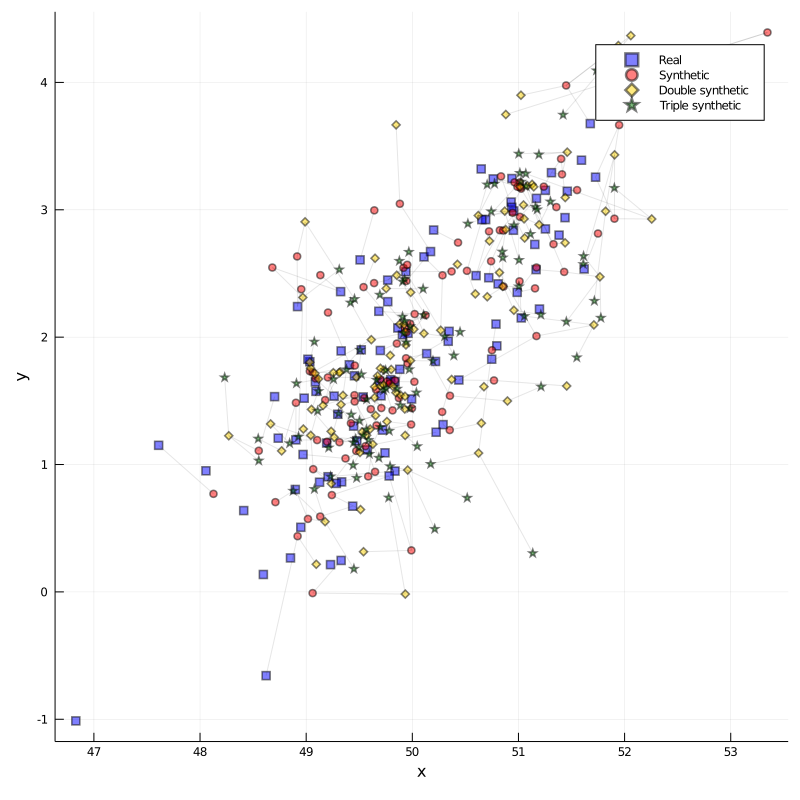

In [55]:
# ╔═╡ 2d157e77-9cb9-49a7-b868-b3e2c8598e8c
let
	# Start a new empty canvas:
	plot(size=(800, 800 ))
	
	for (i, data) in enumerate(coords_datasets)
		if show_dataset[i] == true
			# Scatter the data:
			scatter!(
				data[1, :],
				data[2, :],
				label=labels[i],
				markercolor=colours[i],
				markershape=markers[i],
				linecolor=:black,
				markeralpha=0.5
				)


			if (show_connecting_lines == true) & (i > 1) 
				# Need this condition separately or it'll try to access
				# show_dataset[0] which doesn't exist with 1-indexing.
				if show_dataset[i - 1] == true
					# Plot lines between each synthetic point
					# and the real point it came from.
					for (j, x) in enumerate(data[1, :])
						plot!(
							[coords_base_data[i-1][1, j], data[1, j]],
							[coords_base_data[i-1][2, j], data[2, j]],
							linecolor=:black,
							linealpha=0.1,
							label=""
						)
					end
				end
			end
			
		end
	end
	
	ylabel!("y")
	xlabel!("x")
    
end

In [56]:
# ╔═╡ bff4ef55-ecd4-4406-a69b-fce9fcb79ffc
md"""
## Histograms
"""

## Histograms


In [57]:
# ╔═╡ 634eef0e-fc61-44ac-bbe4-86129c0f76dd
md"""Define shared bins for the histrograms."""

Define shared bins for the histrograms.


In [58]:
# ╔═╡ 20e362ac-aaad-4550-b132-aeed5e0e7041
begin
	# Maximum distance in each data set:
	max_dists = [maximum(dists) for dists in dists_datasets]
	bin_max = maximum([maximum(dists) for dists in max_dists])
	step = 0.05
	# bins = range(0.0, stop=bin_max + step, step=step)
	bins = LinRange(0.0, bin_max, 30)  # Equivalent of linspace()
end

30-element LinRange{Float64, Int64}:
 0.0,0.0644661,0.128932,0.193398,0.257864,…,1.67612,1.74059,1.80505,1.86952

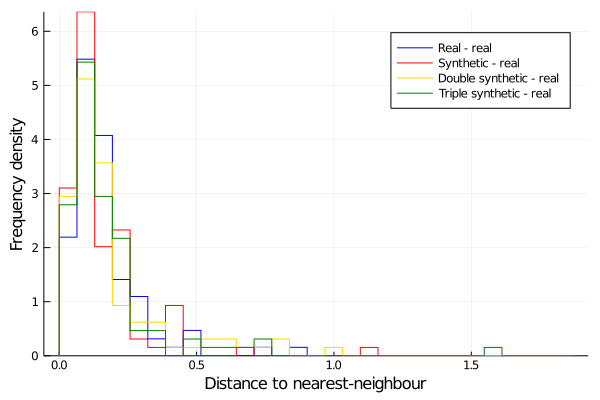

In [59]:
# ╔═╡ 23e8b570-bd98-4323-a232-b40b0efab2e2
let
	# Start a new empty canvas:
	plot()

	for (i, dist) in enumerate(dists_datasets)
		# Step histogram = no vertical lines to zero at bin borders
		stephist!(
			dist,
			bins=bins,
			label=labels[i] * " - real",
			color=false,  # transparency
			linecolor=colours[i],
			# linealpha=0.5,
			normalize=true
			)
	end

	ylabel!("Frequency density")
	xlabel!("Distance to nearest-neighbour")

	# Setting the top limit to infinity keeps the default ymax
	# and allows us to set ymin separately.
	ylims!(0, Inf)
end